In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Locality Sensitive Hashing (LSH)

Supposed we have $n$ elements in our dataset, finding the item which is the most similar to every item in the dataset takes $\binom{n}{2} = O(n^2)$ comparisons. For large values of $n$, this amount of comparison is definitely beyond what is practically manageable. For example:
- Google detects duplicate web pages out of billions.
- Spotify finds songs with similar acoustic fingerprints.
- Plagiarism detection tools spot near-duplicate essays.

These all require fast similarity search in huge, high-dimensional datasets.

## Bruteforce

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def similarity_brute_force(num_vectors=10_000, num_dimensions=300):
    X = np.random.rand(num_vectors, num_dimensions)
    q = np.random.rand(1, num_dimensions)
    
    # Brute force nearest neighbor
    sims = cosine_similarity(q, X)
    nn_index = np.argmax(sims)
    nn_index, sims[0, nn_index]

%timeit similarity_brute_force(1_000_000)

2.39 s ± 142 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


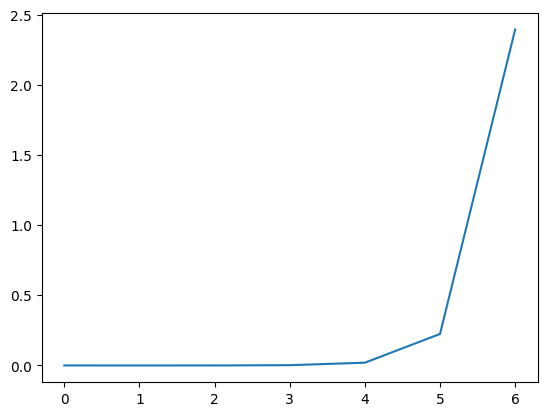

In [14]:
from time import perf_counter_ns

max_magnitude = 7
tm = []
x = [10**i for i in range(max_magnitude)]
for i in range(len(x)):
    repeated = []
    for _ in range(10):  # repeat 10 times to mitigate noise in runtime
        start = perf_counter_ns()
        similarity_brute_force(x[i])
        end = perf_counter_ns() - start
        repeated.append(end * 10**-9)
    tm.append(np.mean(repeated))
plt.plot(np.arange(max_magnitude), tm)

## Minhash

Instead of comparing all elements, MinHash builds a compact signature (a short vector) for each set such that:
- The probability two sets have the same signature entry equals their Jaccard similarity.
- So by comparing signatures, we can approximate Jaccard efficiently.

How MinHash Works:
------------------
1. Choose $k$ independent hash functions 
   $h_1, h_2, \dots, h_k$.

2. For each set $S$, compute:
   $
   \text{MinHash}_i(S) = \min \{ h_i(x) : x \in S \}
   $

3. The signature of $S$ is:
   $
   \big( \text{MinHash}_1(S), \text{MinHash}_2(S), \dots, \text{MinHash}_k(S) \big)
   $